# Imports

In [2]:
!pip install ftfy
!pip install multiprocess


[notice] A new release of pip is available: 24.0 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import os
import glob
import numpy as np
import re
from string import punctuation, whitespace
import warnings
warnings.filterwarnings("ignore")

import ftfy
from sklearn.utils import shuffle
import gc
import matplotlib.pyplot as plt

import multiprocess as mp
from sklearn.feature_selection import mutual_info_classif

# Inputs + Preprocessing

In [4]:
PATH = "input/russian-troll-tweets/"
filenames = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.endswith(".csv")]
print(filenames)
full_ru_trolls = pd.concat((pd.read_csv(f) for f in filenames))
full_ru_trolls.drop(['external_author_id', 'region', 'harvested_date',
        'updates', 'account_type', 'new_june_2018', 'post_type',
        'account_category', 'following', 'followers', 'retweet'],
        axis=1, inplace=True)
full_ru_trolls = full_ru_trolls[full_ru_trolls.content.notnull()]
full_ru_trolls_en = full_ru_trolls[full_ru_trolls.language == 'English'].copy(deep=True)
full_ru_trolls_en.rename(columns={'author': 'account', 'content': 'tweet'}, inplace=True)
full_ru_trolls_en = full_ru_trolls_en[~full_ru_trolls_en.tweet.str.contains('А-Яа-я')]
german_s = re.compile('(Ich )|(Sie )|(Ihnen )|( sich$)|( [Kk]?eine? )|( [Dd]as )|'+
           '^[Dd]as |^[Ss]ind | bist | und | sind | (?!(van|von|-)) der |' + 
           '[ ^][a-z]*ö|[ ^][a-z]*ä|[ ^][a-z]*ü')
full_ru_trolls_en = full_ru_trolls_en[~full_ru_trolls_en.tweet.str.contains(german_s)].copy(deep=True)
del full_ru_trolls
full_ru_trolls_en.drop(['language', 'publish_date'],
        axis=1, inplace=True)
full_ru_trolls_en['troll'] = 1

['input/russian-troll-tweets/IRAhandle_tweets_1.csv', 'input/russian-troll-tweets/IRAhandle_tweets_2.csv', 'input/russian-troll-tweets/IRAhandle_tweets_3.csv', 'input/russian-troll-tweets/IRAhandle_tweets_4.csv', 'input/russian-troll-tweets/IRAhandle_tweets_5.csv', 'input/russian-troll-tweets/IRAhandle_tweets_6.csv', 'input/russian-troll-tweets/IRAhandle_tweets_7.csv', 'input/russian-troll-tweets/IRAhandle_tweets_8.csv', 'input/russian-troll-tweets/IRAhandle_tweets_9.csv']


In [5]:
PATH = "input/RawTwitterFeeds"
filenames = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.endswith(".csv")]
print(filenames)
celebs = pd.concat((pd.read_csv(f) for f in filenames))
celebs.drop(['Unnamed: 0', 'Unnamed: 0.1','id', 'date', 'link', 'retweet'], axis=1,inplace=True)
celebs.rename(columns={'author': 'account', 'text': 'tweet'}, inplace=True)
celebs = celebs[celebs.tweet.notnull()]

sentiment140 = pd.read_csv('input/sentiment140/training.1600000.processed.noemoticon.csv',\
    encoding = 'Latin-1', names=('target', 'id', 'date', 'flag', 'username','tweet'))
sentiment140.drop(['target', 'id', 'date', 'flag'], axis=1, inplace=True)
sentiment140.rename(columns={'username': 'account'}, inplace=True)

['input/RawTwitterFeeds\\10460KDNuggetsTweets.csv', 'input/RawTwitterFeeds\\AdamSavageTweets.csv', 'input/RawTwitterFeeds\\AllTweets.csv', 'input/RawTwitterFeeds\\BarackObama.csv', 'input/RawTwitterFeeds\\DonaldTrump2014-01-01To2016-10-14Tweets.csv', 'input/RawTwitterFeeds\\DonaldTrumpTweets.csv', 'input/RawTwitterFeeds\\FiveThirtyEightTweets.csv', 'input/RawTwitterFeeds\\HillaryClinton2014-01-01To2016-10-14Tweets.csv', 'input/RawTwitterFeeds\\HillaryClintonTweets.csv', 'input/RawTwitterFeeds\\KimKardashianTweets.csv', 'input/RawTwitterFeeds\\NeildeGrasseTysonTweets.csv', 'input/RawTwitterFeeds\\RichardDawkins.csv', 'input/RawTwitterFeeds\\ScottKelly.csv']


In [6]:
used_cols = ['account', 'tweet']
combined = pd.concat([celebs[used_cols], sentiment140[used_cols]], axis=0
                     , ignore_index = True)
#shuffle() from sklearn.utils
combined['troll'] = 0
combined = shuffle(combined, random_state=42).reset_index()
del celebs, sentiment140

In [8]:
print('A number of Twitter accounts in the new data sets is:')
print(combined.account.nunique())
print('The average number of tweets per account is about '+ \
      str(round(len(combined)/combined.account.nunique(), 1)))
combined_tweet_counts = combined.groupby(combined.account).size().reset_index()
combined_tweet_counts.rename(columns={ 0: 'tweet_count'}, inplace=True)
print('The maximal number of posts per account is '+ str(combined_tweet_counts.tweet_count.max()))
print('The minimal number of posts per account is '+ str(combined_tweet_counts.tweet_count.min()))
print("The median number of post per account is " + str(combined_tweet_counts.tweet_count.median()))

A number of Twitter accounts in the new data sets is:
659786
The average number of tweets per account is about 2.7
The maximal number of posts per account is 42871
The minimal number of posts per account is 1
The median number of post per account is 1.0


Один твіт не дасть достатньо інформації про його автора, тому було прийнято рішення брати акаунти з хоча б 10 твітами

In [10]:
def at_least_10_tweets(data, account_col, troll, min_count=10):
    acc_properties = data[[account_col, troll]].groupby(account_col).count()\
            .reset_index()
    acc_properties.rename(columns={'troll': 'tweet_count'}, inplace=True)
    kept_accs = acc_properties[acc_properties.tweet_count >= min_count]
    restricted = data[data.account.isin(kept_accs.account)].copy(deep=True)
    return restricted

combined = at_least_10_tweets(combined, account_col= 'account', troll = 'troll',  min_count=10)
print('A number of Twitter accounts in the new data set is: ')
print(combined.account.nunique())

A number of Twitter accounts in the new data set is: 
21886


In [7]:
ru_trolls =  at_least_10_tweets(full_ru_trolls_en, account_col= 'account', troll = 'troll',  min_count=10)

Функція яка чистить твіт, а також підраховує значення, по списку:

а)
* К-сть URL-адрес
* К-сть хештегів (#hashtag)
* К-сть хендлерів Twitter'а
* К-сть знаків оклику
* К-сть емодзі і тд
* Очищена довжина твіту
* Середня довжина слів

б)
* К-сть ком
* К-сть тире
* К-сть артикля «а»
* К-сть артикля 'the'

In [30]:
# dashes = [chr(int(d, 16)) for d in ['058A', '05BE', '1400', '1806', '2010', '2011',\
#           '2012', '2013', '2014', '2015', '2053', '207B', '208B', '2212', '2E17', \
#           '2E1A', '2E3A', '2E3B', '2E40', '2E5D', '301C', '3030', '30A0', 'FE31', \
#           'FE32', 'FE58', 'FE63', 'FF0D', '10EAD']]
# dashes_compiled = re.compile('[' + ''.join(dashes) + ']+', flags = re.UNICODE)

def cleaning_and_counts(s):
    # Imports/sets here because it'd be executed in subroutine which executes independently from main code
    import ftfy, re, numpy as np
    from string import punctuation, whitespace
    
    # Всі коди дефісу(або аналогічних символів) які я знайшов в текстах
    dashes = [chr(int(d, 16)) for d in ['058A', '05BE', '1400', '1806', '2010', '2011',\
          '2012', '2013', '2014', '2015', '2053', '207B', '208B', '2212', '2E17', \
          '2E1A', '2E3A', '2E3B', '2E40', '2E5D', '301C', '3030', '30A0', 'FE31', \
          'FE32', 'FE58', 'FE63', 'FF0D', '10EAD']]
    dashes_compiled = re.compile('[' + ''.join(dashes) + ']+', flags = re.UNICODE)
    
    s = ftfy.fix_text(s)
    s = re.sub(dashes_compiled, '-', s)     # all dashes should be the same

    url_n = len(re.findall('https?://\\S+\\b', s)) # count urls
    s = re.sub('https?://\\S+\\b', '', s)   # and remove them

    hasht_n = len(re.findall(r'#\w+\b', s)) # count hashtags
    s = re.sub(r'#\w+\b', '', s)            # remove them

    handle_n = len(re.findall(r'@\w{1,15}\b', s)) # count handles
    s = re.sub(r'@\w{1,15}\b', '', s)       # remove them

    s = re.sub('pic\\.twitter\\.com/\\w+\\b', '', s)        # remove pictures. Not expected to impact overall results
    s = re.sub('\\s+', ' ', s)                              # reducing multiple whitespaces to one
    s = s.lstrip(whitespace + punctuation + '\xa0' + chr(8230))   # removing possible whitespaces in front
    s = s.rstrip(whitespace + '\xa0')         # and on the back
    l=''
    emoj_and_such = 0
    for ch in s:
        if ord(ch) < 8204:
            l += ch             # keep a symbol if not emoji or pictogram or such
        else:
            emoj_and_such += 1  # counting emojis and pictograms
    comma_n = len(re.findall(',', s))
    exl_n =  len(re.findall('!', s))
    dash_n = len(re.findall('-', s))
    a_an_n = len(re.findall(r'\b[Aa]n?\b', s))
    the_n = len(re.findall(r'\b[Tt]he\b', s))

    # reduce a number of repeated symbols to no more than 2 
    l = re.sub(r'(.)\1\1+', r'\1\1', l)
    length = len(l)

    words = [len(w) for w in re.findall(r'\b\w+\b', l)]
    if len(words)==0:
        average_word = 0
    else:
        average_word = np.max(words)
    
    return l, url_n, hasht_n, handle_n, emoj_and_such, exl_n, comma_n, dash_n, a_an_n, the_n, length, average_word

In [31]:
%%time
with mp.Pool(processes= mp.cpu_count()) as p:
    combined['tuple'] = p.map(cleaning_and_counts, combined.tweet)

with mp.Pool(processes= mp.cpu_count()) as p:
    ru_trolls['tuple'] = p.map(cleaning_and_counts, ru_trolls.tweet)

CPU times: total: 11.6 s
Wall time: 1min


In [32]:
# Now I need to distribute the created features in separate columns. 
# I specified short integer types for numeric columns to reduce troubles with excessive RAM demand.

features = ("cleaned_tweet, url_n, hasht_n, handle_n, emoji_and_such, "+\
            "exl_n, comma_n, dash_n, " +\
            "a_an_n, the_n, length, average_word").split(', ')

data_list = [combined, ru_trolls]
for df in data_list:
    for i in range(len(features)):
        if i ==0:
            df[features[i]] = df.tuple.apply(lambda t: t[i])
        else:
            df[features[i]] = df.tuple.apply(lambda t: t[i]).astype(np.uint8)

In [33]:
# I want to free some memory and I will need a list of numerical columns.
combined.drop(['tuple'], axis=1,inplace=True)
ru_trolls.drop(['tuple'], axis=1,inplace=True)
gc.collect()
print(features)
num_cols = features[1:]

['cleaned_tweet', 'url_n', 'hasht_n', 'handle_n', 'emoji_and_such', 'exl_n', 'comma_n', 'dash_n', 'a_an_n', 'the_n', 'length', 'average_word']


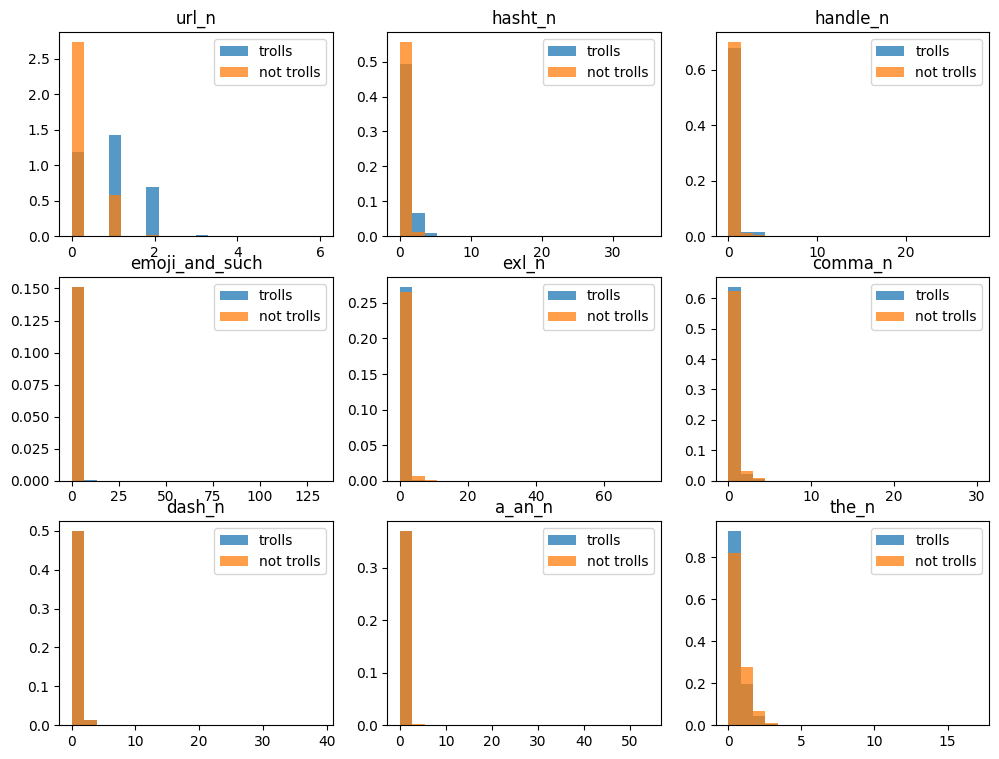

In [34]:
def nine_plots(data1, data2, cols):
    figure, axis = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(12, 9))
    k=0
    for i in range(3):
        for j in range(3):
            upper = data1[cols[k]].max()
            axis[i,j].hist(data1[cols[k]], bins =20, range=[0, upper],\
                     label='trolls', density = True, alpha=.75)
            axis[i,j].hist(data2[cols[k]], bins =20, range=[0, upper],
                     label='not trolls', density = True, alpha=.75)
            axis[i,j].set_title(cols[k])
            axis[i,j].legend()
            k +=1
    plt.show

nine_plots(ru_trolls[num_cols], combined[num_cols], num_cols)

Цікавий феномен: Гістограми не зовсім однакові, але вони багато в чому накладаються.
* Зокрема, ми бачимо очевидний вибір довжини твітів, імовірно, це тому, що тролі мають вказівки щодо своїх публікацій: зберігати свої повідомлення певної довжини, щоб зараховувати їхню щоденну цитату (близько 130 публікацій за зміну).
* Тролі часто можуть уникати публікації повідомлень довше, ніж потрібно, тому що їм доводиться друкувати багато повідомлень.
* Слова тролів загалом довші, і це може бути пов’язано з їхніми інструкціями повторювати окремі слова та вирази з невеликими варіаціями.

# Обчислення фіч
Я вирішив обчислити процентилі для своїх змінних підрахунку. Таким чином можна вловити відмінності в розподілах. Наприклад, 90-процентиль — це значення даних, що 90% усіх записів лежать на гістограмі ліворуч від значення. Її можна апроксимувати так само, як і розрахунки медіани.

In [35]:
colnames = ['account', 'troll'] + num_cols
total_data = pd.concat([combined[colnames], ru_trolls[colnames]], \
                     ignore_index = True)
del ru_trolls, combined, full_ru_trolls_en

In [36]:
%%time
for qu in range(10, 100, 10): 
    percentiles = total_data.groupby('account').quantile(q=qu/100).reset_index()
    cols_to_change = {col : col +'_' + str(qu) for col in num_cols}
    percentiles.rename(columns=cols_to_change, inplace=True)
    if qu == 10:
        all_percentiles = percentiles
    else:
        all_percentiles = pd.merge(all_percentiles, percentiles, how = "left", on = ['account', 'troll'])
    
del total_data
all_percentiles.head()

CPU times: total: 6.61 s
Wall time: 9.56 s


,account,troll,url_n_10,hasht_n_10,handle_n_10,emoji_and_such_10,exl_n_10,comma_n_10,dash_n_10,a_an_n_10,...,hasht_n_90,handle_n_90,emoji_and_such_90,exl_n_90,comma_n_90,dash_n_90,a_an_n_90,the_n_90,length_90,average_word_90
0,007peter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,1.0,0.0,0.0,2.1,0.0,0.1,1.1,124.5,4.1
1,0mgITSkathleen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.1,1.0,65.1,4.0
2,0summerbreeze0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4.2,0.0,0.0,1.0,0.8,115.6,4.0
3,101006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.1,1.0,0.1,1.0,1.1,117.4,4.0
4,101ofawolf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.8,0.0,0.0,1.0,0.0,0.8,1.8,116.2,4.0


In [37]:
new_features = all_percentiles.columns[2:]
zero_cols = [all_percentiles[col].sum()==0 for col in new_features]
print('A number of zero columns is '+str(sum(zero_cols)))
almost_zero = sum([(all_percentiles[col] != 0).sum()<0.005*len(all_percentiles) for col in new_features])
print('Here are only ' + str(almost_zero) + ' of columns with nonzero entries less than .5%.')

A number of zero columns is 0
Here are only 14 of columns with nonzero entries less than .5%.


# Обирання фіч методами MI та кореляції Пірсона

Для машинного навчання я б краще зменшив кількість змінних, щоб пришвидшити обчислення. Я вирішив використати для цього метод МІ, оскільки звичайна кореляція Пірсона може не виявити залежності між випадковими змінними, якщо вона не лінійна. У той же час, коли останній є високим, тоді змінні, ймовірно, будуть дуже схожими. Загальноприйнятим порогом є 0,7, але воно стосується змінних із нормальним розподілом. У нас його немає, тому нам потрібно знайти відповідне максимальне значення кореляції.

Модуль scikit-learn містить методи вибору функцій, які використовують МІ. Є 2 способи його застосування:

* Вибір певної кількості функцій із найвищими оцінками MI
* Вибір певного відсотка функцій із найвищими оцінками.

Я хочу вибрати функції з MI, вищим за вказане порогове значення, і відкинути висококорельовані. Кореляцію перевірятиму за допомогою кореляції Пірсона, оскільки її обчислення набагато швидше, ніж показник MI. У парі з високим ступенем кореляції я віддаю перевагу стовпцю з вищим показником MI. Тому обидва методи scikit-learn мені не підходять.

Нижче ви можете побачити, як деякі з моїх змінних корелюють, особливо коли ми дивимося прямо над головною діагоналлю матриці, і як процентилі того самого підрахунку можуть не сильно корелювати.

In [38]:
all_percentiles[['url_n_10', 'url_n_20', 'url_n_30', 'url_n_40', 'url_n_50', 'url_n_60', 'url_n_70', 'url_n_80', 'url_n_90']].corr()

,url_n_10,url_n_20,url_n_30,url_n_40,url_n_50,url_n_60,url_n_70,url_n_80,url_n_90
url_n_10,1.000000,0.887567,0.808082,0.753038,0.702435,0.668503,0.630882,0.566231,0.454577
url_n_20,0.887567,1.000000,0.915057,0.855422,0.802917,0.759519,0.718007,0.647562,0.526936
url_n_30,0.808082,0.915057,1.000000,0.934582,0.874673,0.822057,0.774885,0.704289,0.599377
url_n_40,0.753038,0.855422,0.934582,1.000000,0.937932,0.876584,0.824190,0.745682,0.648889
url_n_50,0.702435,0.802917,0.874673,0.937932,1.000000,0.937355,0.878231,0.790428,0.687468
url_n_60,0.668503,0.759519,0.822057,0.876584,0.937355,1.000000,0.942086,0.843373,0.723440
url_n_70,0.630882,0.718007,0.774885,0.824190,0.878231,0.942086,1.000000,0.904498,0.764359
url_n_80,0.566231,0.647562,0.704289,0.745682,0.790428,0.843373,0.904498,1.000000,0.843884
url_n_90,0.454577,0.526936,0.599377,0.648889,0.687468,0.723440,0.764359,0.843884,1.000000


Мені потрібно розрідити їх, зберігаючи найбільш корисні змінні. Я буду використовувати метод МІ для вибору хороших змінних. Постійні стовпці матимуть 0 оцінок MI, тому я відкину їх разом зі стовпцями з низьким показником MI, якщо такі є. 

Нижче ви бачите список нових фіч, упорядкованих за результатами MI зі статусом троля. Вони впорядковані за показником MI у порядку спадання.

In [39]:
mi = mutual_info_classif(all_percentiles[new_features].values, all_percentiles.troll.values, n_neighbors= 19)
cols_mi = list(zip(new_features, mi))
cols_mi.sort(reverse = True, key=lambda x: x[1])
cols_mi = [pair[0] for pair in cols_mi if pair[1] > 0.001]
print(cols_mi)

['hasht_n_90', 'hasht_n_80', 'url_n_90', 'url_n_80', 'hasht_n_70', 'url_n_70', 'hasht_n_60', 'url_n_60', 'average_word_90', 'average_word_80', 'url_n_50', 'hasht_n_50', 'average_word_70', 'url_n_40', 'hasht_n_40', 'handle_n_80', 'average_word_60', 'handle_n_90', 'hasht_n_30', 'average_word_50', 'average_word_40', 'url_n_30', 'handle_n_70', 'average_word_30', 'hasht_n_20', 'url_n_20', 'emoji_and_such_90', 'handle_n_60', 'average_word_20', 'hasht_n_10', 'exl_n_70', 'length_30', 'url_n_10', 'exl_n_90', 'length_20', 'exl_n_80', 'exl_n_60', 'average_word_10', 'length_10', 'handle_n_50', 'length_90', 'comma_n_90', 'dash_n_90', 'length_70', 'length_80', 'length_40', 'length_60', 'comma_n_70', 'exl_n_50', 'comma_n_60', 'a_an_n_70', 'handle_n_40', 'exl_n_40', 'the_n_90', 'emoji_and_such_80', 'length_50', 'comma_n_50', 'a_an_n_80', 'a_an_n_90', 'emoji_and_such_70', 'handle_n_30', 'exl_n_30', 'comma_n_80', 'a_an_n_60', 'the_n_80', 'the_n_60', 'comma_n_40', 'exl_n_20', 'the_n_70', 'emoji_and_such_

Як ми бачимо, найбільш значущими функціями є ті, що стосуються методів пропаганди: хештеги, URL-адреси, середня довжина слова, хендли Twitter. 

* Я запустив для них логістичну регресію та отримав хорошу точність тестового набору: 98%. Мені було цікаво, чи можу я отримати кращу точність за допомогою нелінійних методів. 
* У той же час я хотів би зменшити кількість змінних. Для цього я використаю кореляцію Пірсона, оскільки вона швидко обчислює, і якщо вона висока, змінні, безумовно, сильно залежать одна від одної. (Коли він низький, ми не впевнені.) 
* Я міг би знову використати метод MI, щоб перевірити наявність залежності між змінними, але для обчислення потрібно багато часу.
* Функція, наведена нижче, видаляє висококорельовані змінні з нашого списку, зберігаючи ті, що мають кращий показник MI.

In [40]:
def drop_correlated(data, sorted_cols, threshold=.8):
    new = [[sorted_cols[0]], [0]]
    corr_matrix = data[sorted_cols].corr().values
    N = len(sorted_cols)
    for i in range(1, N):
        tr = corr_matrix[new[1], i]
        if sum(np.abs(tr) >threshold)==0:
            new[0] += [sorted_cols[i]]
            new[1] += [i]
    return new[0]

In [41]:
new_cols =  drop_correlated(all_percentiles[new_features], cols_mi, threshold =.75)
print('A number of selected columns is: ' + str(len(new_cols)))
print(new_cols)

A number of selected columns is: 45
['hasht_n_90', 'url_n_90', 'url_n_60', 'average_word_90', 'average_word_80', 'hasht_n_50', 'average_word_70', 'handle_n_80', 'average_word_60', 'average_word_50', 'average_word_40', 'average_word_30', 'emoji_and_such_90', 'handle_n_60', 'average_word_20', 'hasht_n_10', 'exl_n_70', 'length_30', 'url_n_10', 'average_word_10', 'length_90', 'comma_n_90', 'dash_n_90', 'comma_n_70', 'a_an_n_70', 'handle_n_40', 'exl_n_40', 'the_n_90', 'comma_n_50', 'a_an_n_80', 'a_an_n_90', 'emoji_and_such_70', 'handle_n_30', 'a_an_n_60', 'the_n_80', 'the_n_60', 'exl_n_20', 'the_n_70', 'handle_n_20', 'a_an_n_40', 'the_n_50', 'a_an_n_50', 'the_n_40', 'handle_n_10', 'emoji_and_such_50']


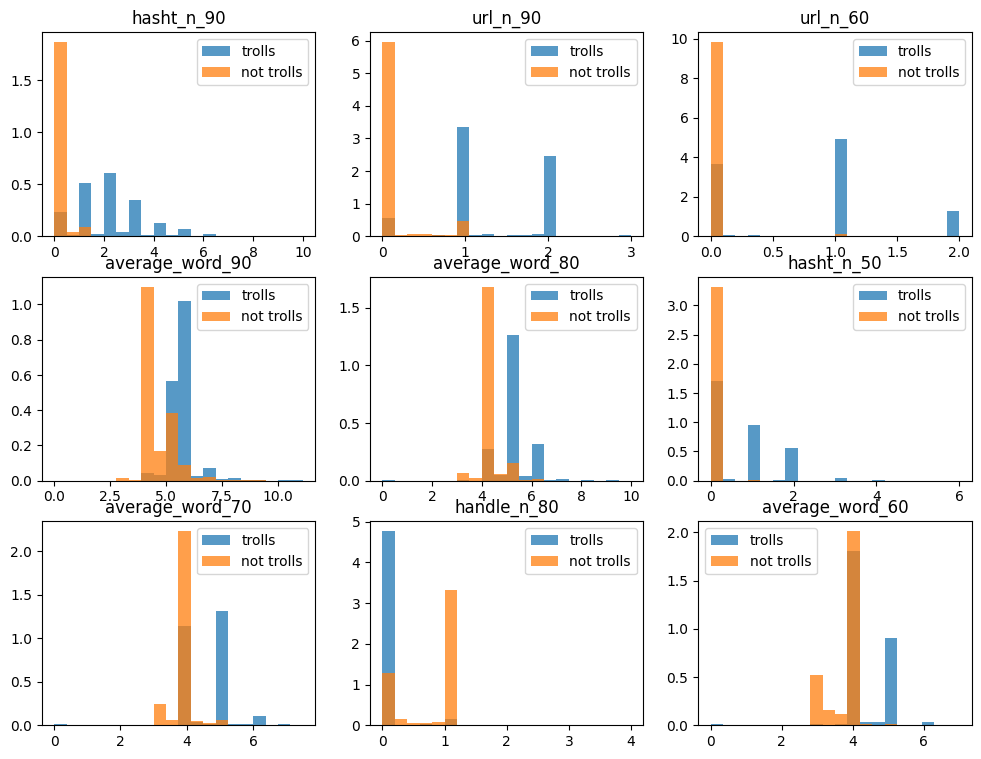

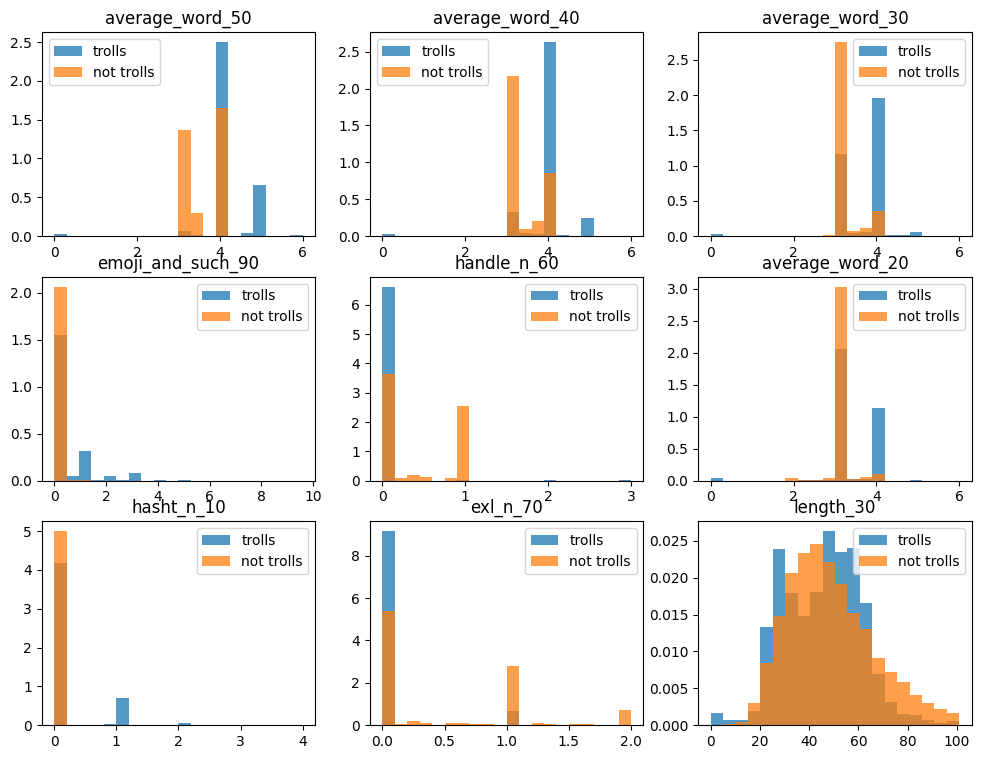

In [42]:
яnine_plots(all_percentiles[all_percentiles.troll==1], all_percentiles[all_percentiles.troll==0], new_cols[:9])
nine_plots(all_percentiles[all_percentiles.troll==1], all_percentiles[all_percentiles.troll==0], new_cols[9:18])